In [1]:
import numpy as np
from pymatgen import Molecule
from pymatgen.io.qchem import QcTask, QcOutput
import math

# Get dihedral angle and energy from qchem files

In [2]:
import os 
import re

In [3]:
# this is not placed in utils yet because error checking hasn't been finalized
def get_energy_dihedral(directory):
    dihedral, energy = [], []
    for f in os.listdir(directory):
        if ".qcout" in f:
            if ".orig" not in f:
                output = QcOutput('{d}/{f}'.format(d=directory,f=f))
                qchem_in = output.data[-1]['input']
                try:
                    energy.append(output.final_energy)
                except IndexError:
                    energy.append('no energy') 
                constraints = qchem_in.params['opt']
                for l in constraints:
                    if 'tors' in l:
                        dihedral.append(l[len(l)-1])
    return dihedral, energy

In [4]:
dihedral, energy = get_energy_dihedral('./pt_cust_dft_full')

# Fit and plot dihedral potential

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from scipy.optimize import curve_fit

In [7]:
# Ryckaert_Bellemans dihedral potential function
def RB_potential(x, a, b, c, d, e, f):
    return (a*1.0 + b*np.cos(x*np.pi/180.0) 
            + c*(np.cos(x*np.pi/180.0)**2) 
            + d*(np.cos(x*np.pi/180.0)**3) 
            + e*(np.cos(x*np.pi/180.0)**4) 
            + f*(np.cos(x*np.pi/180.0)**5))

In [8]:
import utils

In [9]:
rel_eV_energy = utils.relative_energy(energy)

In [10]:
fit_params, fit_covar = curve_fit(RB_potential,dihedral,rel_eV_energy)

In [11]:
# create list of angles and corresponding energies
angles = np.linspace(-179, 180, 4000)
RB_energy = [RB_potential(angle, fit_params[0], fit_params[1], 
                          fit_params[2], fit_params[3], fit_params[4], 
                          fit_params[5]) for angle in angles]

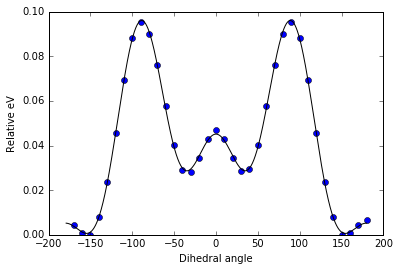

In [12]:
plt.figure()
plt.plot(dihedral, rel_eV_energy, 'o', angles, RB_energy, 'black')
plt.xlabel('Dihedral angle')
plt.ylabel('Relative eV')
plt.show()

In [13]:
fit_params

array([ 0.09589618,  0.00937093, -0.21725121,  0.00549039,  0.14653387,
        0.00507763])

# Boltzmann distribution

In [14]:
# kbT in eV/KS
kb_eV_K = 8.6173324 * 10**-5

In [15]:
kbT700 = kb_eV_K * 700.0
kbT300 = kb_eV_K * 300.0

In [16]:
# normalization 
boltz_factor_700 = [np.exp(-energy / kbT700) for energy in RB_energy]
normalize_val = sum(boltz_factor_700)

In [17]:
prob_700 = [(np.exp(-energy / kbT700) / normalize_val) for energy in RB_energy]

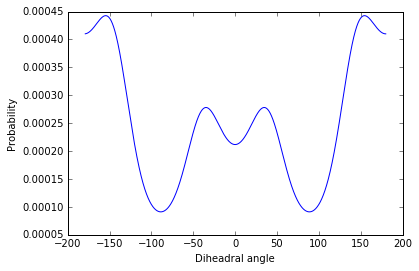

In [18]:
plt.figure()
plt.plot(angles, prob_700)
plt.xlabel('Diheadral angle')
plt.ylabel('Probability')
plt.show()

# Map dihedral angles to random numbers between 0-1

In [19]:
cum_prob = [sum(prob_700[0:prob_i]) for prob_i in range(len(prob_700))]

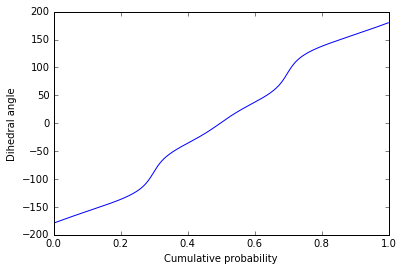

In [20]:
plt.figure()
plt.plot(cum_prob, angles)
plt.xlabel('Cumulative probability')
plt.ylabel('Dihedral angle')
plt.show()

In [21]:
len(angles)

4000

In [22]:
fake_x = np.linspace(0.0, .9999, 1200)
fake_x

array([  0.00000000e+00,   8.33944954e-04,   1.66788991e-03, ...,
         9.98232110e-01,   9.99066055e-01,   9.99900000e-01])

In [23]:
angles_frm_poly = [(cum_params[0]*x**5 + 
                    cum_params[1]*x**4 + 
                    cum_params[2]*x**3 + 
                    cum_params[3]*x**2 + 
                    cum_params[4]*x**1 + 
                    cum_params[5]) for x in fake_x]

NameError: name 'cum_params' is not defined

In [ ]:
plt.figure()
plt.plot(fake_x, angles_frm_poly)
plt.xlabel('cum_prob')
plt.ylabel('dihedral')
plt.show()

In [ ]:
cum_params_RB, covar = curve_fit(RB_potential, cum_prob , angles)
cum_params

In [ ]:
RB_angles = [RB_potential(cum_probs, cum_params_RB[0], cum_params_RB[1], 
                          cum_params_RB[2], cum_params_RB[3], cum_params_RB[4], 
                          cum_params_RB[5]) for cum_probs in cum_prob]

In [ ]:
plt.figure()
plt.plot(cum_prob, RB_angles)
plt.xlabel('cum_prob')
plt.ylabel('dihedral')
plt.show()

In [ ]:
def h_tan(x, a, b, c, d):
    return ((a*1.0 + (b * np.tanh(x*np.pi/180.0))) + (c*1.0 + (d * (np.tanh(x*np.pi/180.0)))))

In [ ]:
tanh_params, tanh_covar = curve_fit(h_tan, cum_prob, angles)
tanh_params

In [ ]:
tanh_angles = [h_tan(cum_probs, tanh_params[0], tanh_params[1], tanh_params[2], tanh_params[3]) for cum_probs in cum_prob]

In [ ]:
plt.figure()
plt.plot(cum_prob, tanh_angles)
plt.xlabel('cum_prob')
plt.ylabel('dihedral')
plt.show()

In [ ]:
tanh_vals = [np.tanh(x) for x in cum_prob]

In [ ]:
plt.figure()
plt.plot(cum_prob, tanh_vals)
plt.xlabel('cum_prob')
plt.ylabel('dihedral')
plt.show()

In [ ]:
#from scipy.interpolate import interp1d

In [ ]:
angle_map = np.array(zip(cum_prob, angles))
#angle_map = interp1d(cum_prob, angles, kind='cubic')

In [ ]:
#angle_map = np.array(zip(cum_prob, angles))

In [ ]:
#angle_map([0.0])

In [ ]:
#angle_map(np.random.uniform(0.0, 1.0, size=(25)))

In [ ]:
np.random.randint(0, 3000, size=25)

# Build, relax, and sample neutral chain

In [24]:
from polymer_chain import Polymer

In [25]:
monomer_num = 25
monomer_len = 2.548
link_len = 1.480
link_angle = 15.0
n_prob_angle = angles
sample_num = 100

In [26]:
pt_neutal = Polymer(monomer_num, monomer_len, link_len, link_angle, n_prob_angle, sample_num)

In [27]:
#pt_neutal.build_chain()
#pt_neutal.relax_neutral_chain()

In [28]:
ave_ete, ave_corr = pt_neutal.sample_neutral_chains()

[ 824  290 3003  138  343 1361  128 2050 1057 2641  640 3425  838   86 1224
  764 2272 3352 3282  108 3070 2135 3425  466]
[1976  586  253 3352 2229 3451  496   36 2026  368 3871  245 2692  160 1779
 3408 1421 1314  977 3762  681 1097 1853  569]
[2121 2906 3577 1948 1955 1482 1235 1098 2785  700 1896 1407 2817 3588 3278
 2570 3406 2594 2134 1490 2628 2501  923 3527]
[1629 2116 3108 1968 1068 3679 3592 2264  669 3777 1141 1733 1925 1207 2124
 3043 3468 1869 3082 1819  637 1708  912 2824]
[ 695 1345 1680 2839 1015 3352 1537 3499 2789 2816 2803 2988 1717 2805 3855
 2255 2637 2709 3411 3517 3880  497 2575 1562]
[2311 1406 1376  846 2675  825  438 1577   91 1464   13 2896  657  529 2150
 3720 1036 3161 2888 1226 1105 2434 1537  653]
[3879 2344  217  379   37 3456 3134 1005 2139 2517 1777 2940  430 3901  410
  205 1845 1358  342 2106 3765 3003 3987  154]
[2107  582 1895 1027  495 2220 3204 3912 3457 3555 3504 2327 1639 3190 2794
 2640 2569 1031  418 3478 2944 1878  276 1922]
[ 520 3357 2474 

In [ ]:
plt.figure()
plt.plot(range(0, monomer_num + 1, 1), ave_ete)
plt.xlabel('number of monomers')
plt.ylabel('average end_to_end distance')
plt.show()

In [ ]:
ave_ete

In [ ]:
plt.figure()
plt.plot(range(0, monomer_num + 1, 1), ((ave_ete * ave_ete)*0.01))
plt.xlabel('number of monomers')
plt.ylabel('average end_to_end distance')
plt.show()

In [ ]:
plt.figure()
plt.plot(range(0, monomer_num, 1), ave_corr)
plt.xlabel('number of monomers')
plt.ylabel('correlation')
plt.show()

In [ ]:
plt.figure()
plt.plot(range(0, monomer_num, 1), np.log(ave_corr))
plt.xlabel('number of monomers')
plt.ylabel('correlation')
plt.show()

# Timeit

In [ ]:
%load_ext line_profiler

In [ ]:
%prun pt_neutal.relax_neutral_chain()

In [65]:
a = 0.0
b = 1.0
c = 0.0
d = 2.0
x_vals = np.linspace(-4.0, 4.0, 100)
tan_vals = [((a + b*np.tanh(1+x)) + (c + d*np.tanh(1+x))) for x in x_vals]

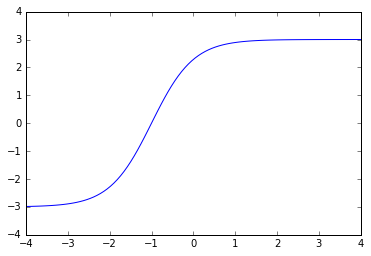

In [66]:
plt.figure()
plt.plot(x_vals, tan_vals)
plt.xlim(-4.0, 4.0)
plt.ylim(-4.0, 4.0)
plt.show()